In [1]:
using Revise
import Random
Random.seed!(0)
pwd()

"/Users/bach/OneDrive - Politechnika Warszawska/projects/2019/iskra"

In [2]:
include("problem/units_and_constants.jl")
include("problem/configuration.jl")
config = Config();

┌ Info: Recompiling stale cache file /Users/bach/.julia/compiled/v1.1/ParticleInCell.ji for ParticleInCell [top-level]
└ @ Base loading.jl:1184


In [3]:
nx = 10         # number of nodes in x direction
ny = 10         # number of nodes in y direction
ts = 250        # number of time steps
Δh = 10cm       # cell size
Δt = 10ns       # time step
Lx = nx*Δh      # domain length in x direction
Ly = ny*Δh      # domain length in y direction
nothing

In [4]:
xs, ys = 0m:Δh:Lx, 0m:Δh:Ly
e = create_kinetic_species("e-", 50_000,-1qe, 1me, 50e3)
γ = create_thermalized_beam(e, [Lx/4 Ly/2], [0. 0. 0.];
  dx=[Lx/4 Ly/4], rate=20_000/Δt)

MaxwellianSource{2,3}(2.0e12, [0.25 0.5], [0.25 0.25], [95361.4 95361.4 95361.4], [0.0 0.0 0.0])

In [5]:
using RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = create_uniform_grid(xs, ys)
config.cells   = create_staggered_grid(config.grid)
config.solver  = create_poisson_solver(config.grid, ε0)
config.pusher  = create_boris_pusher()
config.species = [e]

1-element Array{KineticSpecies{2,3},1}:
 e-

In [6]:
nx, ny = size(config.grid)
bcs = zeros(Int8, nx, ny)
bcs[ 1, 2:ny-1] .= 1
bcs[nx,    5:7] .= 2
bcs[nx-1,    1]  = 3
bcs[nx-1,   ny]  = 3
bcs[6:8,   5:7] .= 4
reflecting = ParticleInCell.create_reflective_surface()
driven   = create_electrode(bcs .== 1, config; σ=1ε0)
floating = create_electrode(bcs .== 2, config)
grounded = create_electrode(bcs .== 3, config; fixed=true)
ParticleInCell.track_surface!(config.tracker, bcs .== 4, reflecting)

In [7]:
using Diagnostics

function ParticleInCell.after_loop(i, t, dt)
  cd("/tmp")
  new_iteration("07_boundaries", i, t, dt) do it
    save_records(it, "e-/")
    save_record(it, "ne-")
    save_record(it, "phi")
    save_record(it, "E")
  end
end

nothing

In [8]:
ParticleInCell.init(γ, e, Δt)
@time ParticleInCell.solve(config, Δt, ts)

Registering diagnostics e-/id
Registering diagnostics e-/mass
Registering diagnostics e-/charge
Registering diagnostics e-/weighting
Registering diagnostics e-/momentum
Registering diagnostics e-/position
Registering diagnostics e-/positionOffset/x
Registering diagnostics e-/positionOffset/y
Registering diagnostics e-/positionOffset/z
Registering diagnostics ne-
Registering diagnostics rho
Registering diagnostics phi
Registering diagnostics E
Time Step #1
Time Step #2
Time Step #3
Time Step #4
Time Step #5
Time Step #6
Time Step #7
Time Step #8
Time Step #9
Time Step #10
Time Step #11
Time Step #12
Time Step #13
Time Step #14
Time Step #15
Time Step #16
Time Step #17
Time Step #18
Time Step #19
Time Step #20
Time Step #21
Time Step #22
Time Step #23
Time Step #24
Time Step #25
Time Step #26
Time Step #27
Time Step #28
Time Step #29
Time Step #30
Time Step #31
Time Step #32
Time Step #33
Time Step #34
Time Step #35
Time Step #36
Time Step #37
Time Step #38
Time Step #39
Time Step #40
Ti

### Analysis

In [9]:
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/07_boundaries/hdf5");

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


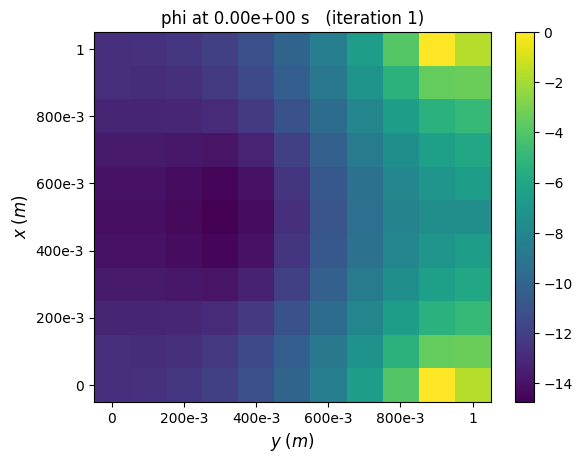

In [10]:
ts.get_field("phi", iteration=1, plot=true);

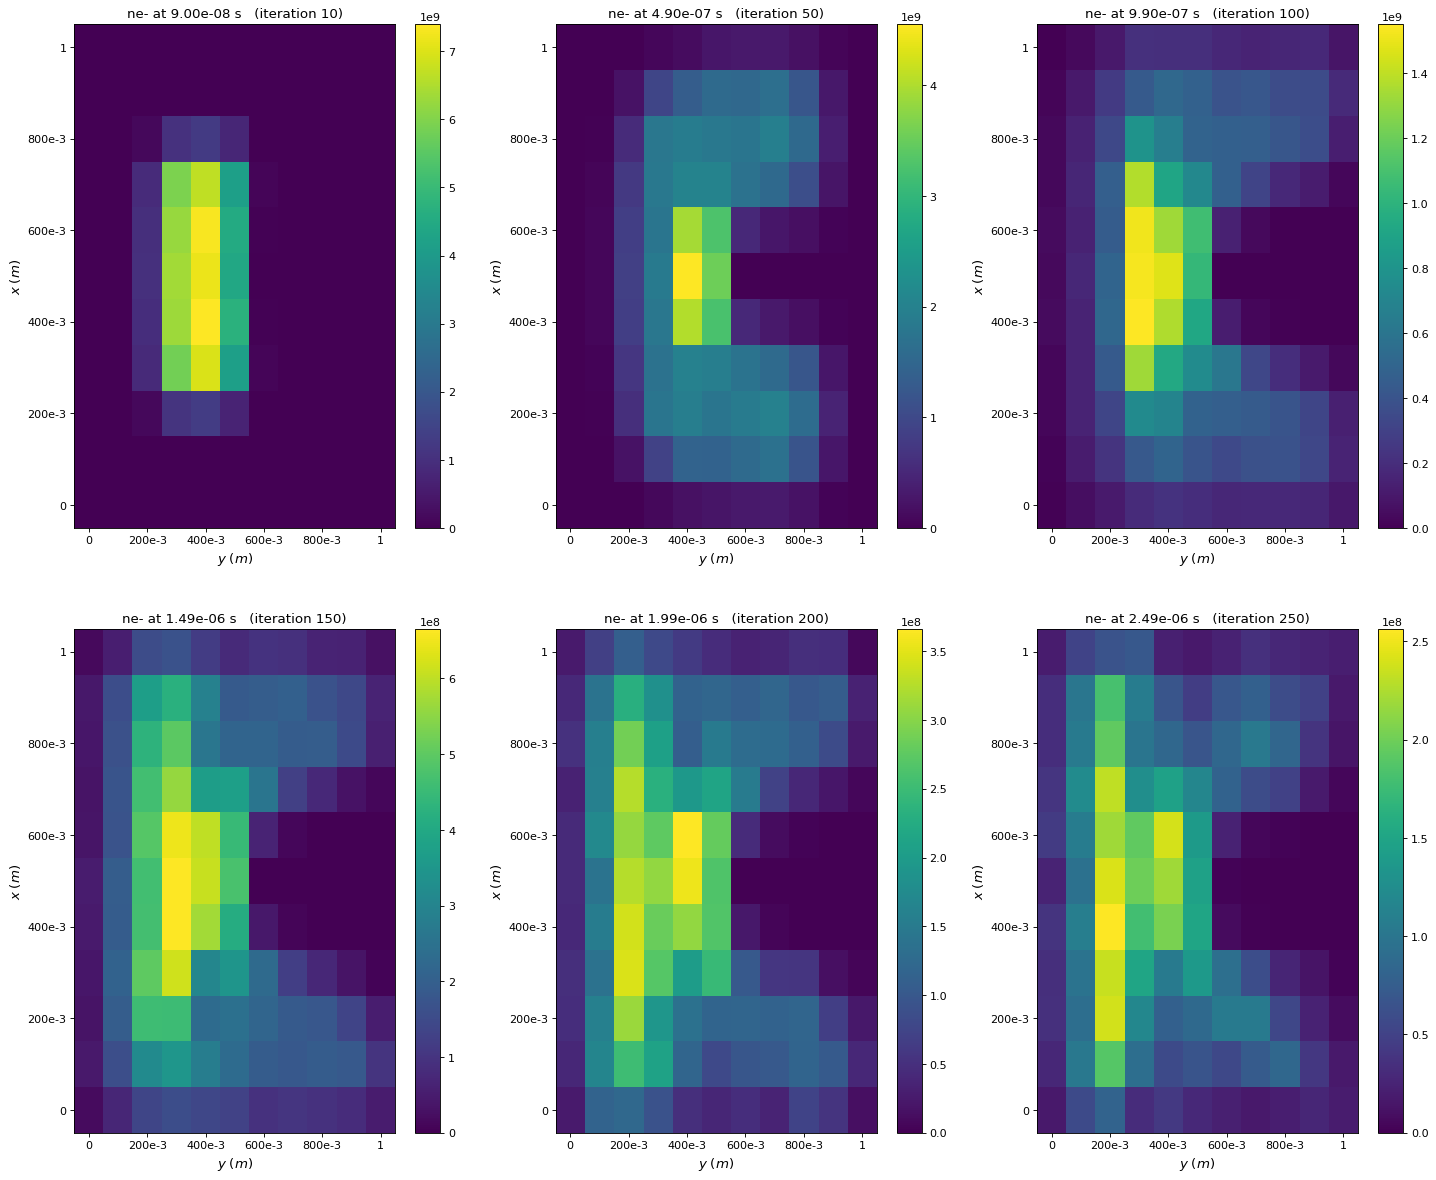

In [11]:
fig = plt.figure(figsize=(22, 18), dpi=80, facecolor="w", edgecolor="k")

plt.subplot(2, 3, 1); ts.get_field("ne-", iteration=10,  plot=true);
plt.subplot(2, 3, 2); ts.get_field("ne-", iteration=50,  plot=true);
plt.subplot(2, 3, 3); ts.get_field("ne-", iteration=100, plot=true);
plt.subplot(2, 3, 4); ts.get_field("ne-", iteration=150, plot=true);
plt.subplot(2, 3, 5); ts.get_field("ne-", iteration=200, plot=true);
plt.subplot(2, 3, 6); ts.get_field("ne-", iteration=250, plot=true);

In [12]:
using XDMF
cd("/tmp/07_boundaries")
electrons = new_document()
fields = new_document()
xdmf(1:250) do it
    write_species(it, electrons, "e-")
    write_fields(it, fields)
end
save_document(electrons, "electrons")
save_document(fields, "fields")

430006